In [1]:
# vim: set filetype=python:

# Variational Logistic Regression

Both Variational Logistic Regression (VLR) and Bayesian Logistic Regression with Laplace Approximation (BLR) select penalisation term for coefficients automatically, however VLR is much slower since it needs to optimize latent variational parameter for each observation. In case of large number of samples it is advised to use BLR, however in case of small sample size VLR has better approximation to posterior distribution and is therefor expected to be more accurate.

## scikit-learn API¶

In [1]:
# test using scikit-learn unit tests for linear classifier
from vblr import VariationalLogisticRegression 
from sklearn.utils.estimator_checks import check_estimator
check_estimator(VariationalLogisticRegression)
print 'Passed all tests'

Passed all tests


## Demo example

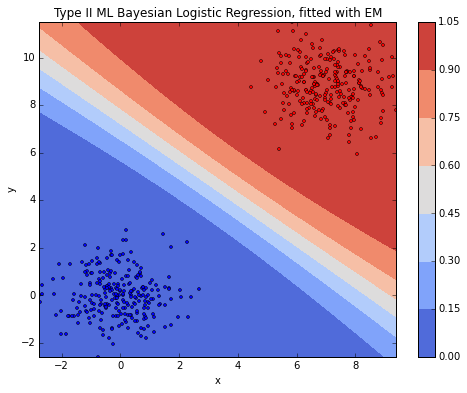

In [2]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LogisticRegression   
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline

# create data set 
np.random.seed(0)
x          = np.zeros([500,2])
x[:,0]     = np.random.normal(0,1,500) 
x[:,1]     = np.random.normal(0,1,500) 
x[0:250,0] = x[0:250,0] + 7
x[0:250,1] = x[0:250,1] + 9
#x          = x - np.mean(x,0)
#x          = scale(x)
y          = -1*np.ones(500)
y[0:250]   = 1
blr        = VariationalLogisticRegression()
blr.fit(x,y)

# create grid for heatmap
n_grid = 500
max_x      = np.max(x,axis = 0)
min_x      = np.min(x,axis = 0)
X1         = np.linspace(min_x[0],max_x[0],n_grid)
X2         = np.linspace(min_x[1],max_x[1],n_grid)
x1,x2      = np.meshgrid(X1,X2)
Xgrid      = np.zeros([n_grid**2,2])
Xgrid[:,0] = np.reshape(x1,(n_grid**2,))
Xgrid[:,1] = np.reshape(x2,(n_grid**2,))

blr_grid   = blr.predict_proba(Xgrid)[:,1]
plt.figure(figsize=(8,6))
plt.contourf(X1,X2,np.reshape(blr_grid,(n_grid,n_grid)),cmap="coolwarm")
plt.plot(x[y==-1,0],x[y==-1,1],"bo", markersize = 3)
plt.plot(x[y==1,0],x[y==1,1],"ro", markersize = 3)
plt.colorbar()
plt.title("Variational Logistic Regression")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

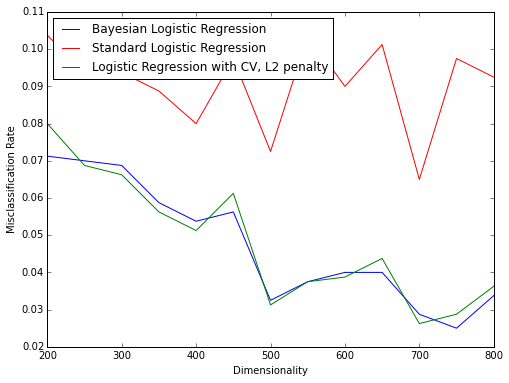

In [4]:
from scipy import stats
from sklearn.preprocessing import scale
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
import matplotlib.pyplot as plt

def bayesian_vs_freq(n_samples,i):
    X = np.random.randn(n_samples, i)
    # Create weigts
    lambda_ = 10
    w = np.zeros(i)
    relevant_features = np.random.randint(0, i, 40)
    for i in relevant_features:
       w[i] = stats.norm.rvs(loc=0, scale=1. / np.sqrt(lambda_))
    # Create the target
    y = np.dot(X, w) + 10
    y_hat  = np.ones(y.shape[0])
    y_hat[y < 10] = -1
    X[y_hat>0,:] = X[y_hat>0,:] + 0.15
    X,x,Y,y = train_test_split(X,y_hat, test_size = 0.1)
    blr  = VariationalLogisticRegression(n_iter = 100)
    blr.fit(X,Y)
    lr   = LogisticRegression(C = 1e+5)
    lr.fit(X,Y)
    lrcv = LogisticRegressionCV(Cs = [0.1,1,10,100])
    lrcv.fit(X,Y)
    y_blr = blr.predict(x)
    y_lr = lr.predict(x)
    y_lrcv = lrcv.predict(x)
    
    return [float(np.sum(y_blr!=y))/x.shape[0], float(np.sum(y_lr!=y))/x.shape[0],
            float(np.sum(y_lrcv!=y))/x.shape[0]]


def simulation(n_samples,i,iter = 100):
    blr, lr, lrcv = [],[],[]
    for j in range(iter):
        b,l,lcv = bayesian_vs_freq(n_samples,i)
        blr.append(b); lr.append(l)
        lrcv.append(lcv)
    return np.mean(blr),np.mean(lr), np.mean(lrcv)


err_lr    = []
err_lrcv  = []
err_blr   = []
n_samples = 800
dims    = [200,250,300,350,400,450,500,550,600,650,700,750,800]

for i in dims:
    eb, el, elcv = simulation(n_samples,i,10)
    err_blr.append(eb)
    err_lr.append(el)
    err_lrcv.append(elcv)
    
# plot results    
plt.figure(figsize = (8,6))
plt.plot(dims,err_blr,'b-',label = 'Bayesian Logistic Regression')
plt.plot(dims,err_lr,'r-', label = 'Standard Logistic Regression')
plt.plot(dims,err_lrcv,'g-', label = 'Logistic Regression with CV, L2 penalty')
plt.xlabel('Dimensionality')
plt.ylabel('Misclassification Rate')
plt.legend(loc = 2)
plt.show()  

For large number of noisy features Variational Logistic Regression performs as good as cross-validated Logistic Regression with L2 penalty.